In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler


import re
import itertools

In [144]:
papers = pd.read_csv("arXiv_scientific dataset.csv")

In [145]:
papers.head(5)

,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count
0,cs-9308101v1,Dynamic Backtracking,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. L. Ginsberg'],'M. L. Ginsberg',Because of their occasional need to return to ...,79
1,cs-9308102v1,A Market-Oriented Programming Environment and ...,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. P. Wellman'],'M. P. Wellman',Market price systems constitute a well-underst...,119
2,cs-9309101v1,An Empirical Analysis of Search in GSAT,Artificial Intelligence,cs.AI,9/1/93,9/1/93,"['I. P. Gent', 'T. Walsh']",'I. P. Gent',We describe an extensive study of search in GS...,167
3,cs-9311101v1,The Difficulties of Learning Logic Programs wi...,Artificial Intelligence,cs.AI,11/1/93,11/1/93,"['F. Bergadano', 'D. Gunetti', 'U. Trinchero']",'F. Bergadano',As real logic programmers normally use cut (!)...,174
4,cs-9311102v1,Software Agents: Completing Patterns and Const...,Artificial Intelligence,cs.AI,11/1/93,11/1/93,"['J. C. Schlimmer', 'L. A. Hermens']",'J. C. Schlimmer',To support the goal of allowing users to recor...,187


**Validation**

In [146]:
papers.duplicated().any()

False

**Top 20**

In [147]:
top20 = papers['category'].value_counts().head(20).index.tolist()
papersTop20 = papers[papers['category'].isin(top20)].copy()

**Exploding Authors**

In [148]:
authors = papersTop20[['id', 'authors', 'category']].copy()
def extract_authors(text):
    return re.findall(r"'([^']+)'", text)
authors['authors'] = authors['authors'].apply(extract_authors)
authors

authorsExploded = authors.explode('authors')

**Matrix Category**

In [149]:
authorMatrix = pd.pivot_table(
    authorsExploded,
    index='authors',
    columns='category',
    aggfunc='size',
    fill_value=0
)
authorMatrixArray = authorMatrix.values

**Elbow Method**

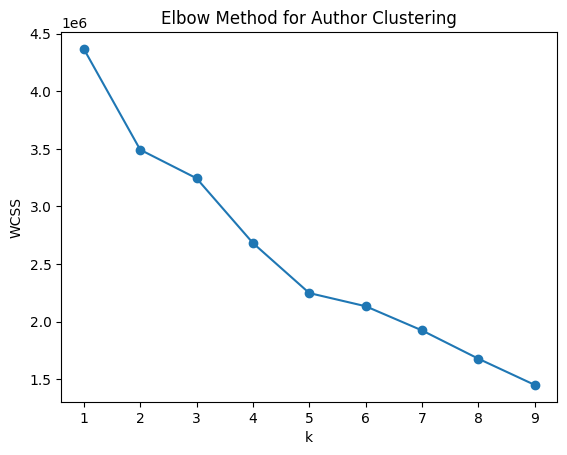

In [150]:
wcss = []
K = range(1, 10)

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(authorMatrixArray)
    wcss.append(model.inertia_)

plt.plot(K, wcss, 'o-')
plt.xlabel("k")
plt.ylabel("WCSS")
plt.title("Elbow Method for Author Clustering")
plt.show()

In [151]:
authorMatrix.head()

category,Applications (Statistics),Artificial Intelligence,Computation and Language (Legacy category),Computation and Language (Natural Language Processing),Computer Vision and Pattern Recognition,Computers and Society,Cryptography and Security,"Distributed, Parallel, and Cluster Computing",Human-Computer Interaction,Information Retrieval,Machine Learning,Machine Learning (Statistics),Methodology (Statistics),Neural and Evolutionary Computing,Neurons and Cognition,Optimization and Control,Robotics,Signal Processing,Social and Information Networks,Software Engineering
authors,,,,,,,,,,,,,,,,,,,,
.,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
210,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
:,0,1,1,3,0,1,0,0,0,0,1,0,0,2,0,0,0,0,0,0
Aakanksha,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Aakriti,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


**Clustering**

In [152]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(authorMatrix)

authorMatrix['cluster'] = clusters
clusterProfiles = authorMatrix.groupby('cluster').mean()

In [153]:
for cluster_id in range(k):
    topCats = clusterProfiles.loc[cluster_id].sort_values(ascending=False).head(3)
    print(topCats)

category
Machine Learning                                          0.628986
Computer Vision and Pattern Recognition                   0.501613
Computation and Language (Natural Language Processing)    0.445402
Name: 0, dtype: float64
category
Computation and Language (Natural Language Processing)    29.559343
Machine Learning                                           2.901515
Computer Vision and Pattern Recognition                    1.987374
Name: 1, dtype: float64
category
Artificial Intelligence                                   282.0
Machine Learning                                          279.0
Computation and Language (Natural Language Processing)    279.0
Name: 2, dtype: float64
category
Computer Vision and Pattern Recognition                   22.518025
Machine Learning                                           3.682602
Computation and Language (Natural Language Processing)     1.692790
Name: 3, dtype: float64
category
Machine Learning                           17.426045
Machi

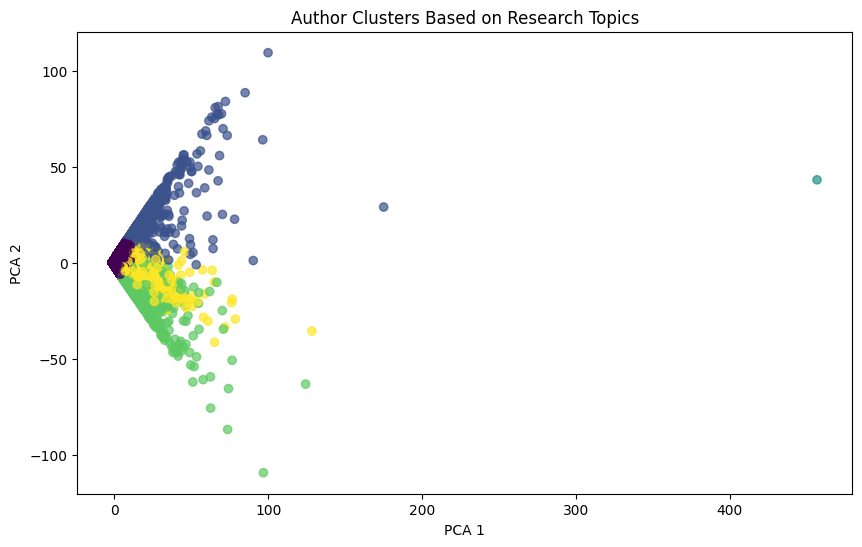

In [154]:
X = authorMatrix.drop(columns=['cluster'])

pca = PCA(n_components=2)
coords = pca.fit_transform(X)

plt.figure(figsize=(10,6))
plt.scatter(coords[:,0], coords[:,1], c=authorMatrix['cluster'], alpha=0.7)
plt.title("Author Clusters Based on Research Topics")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

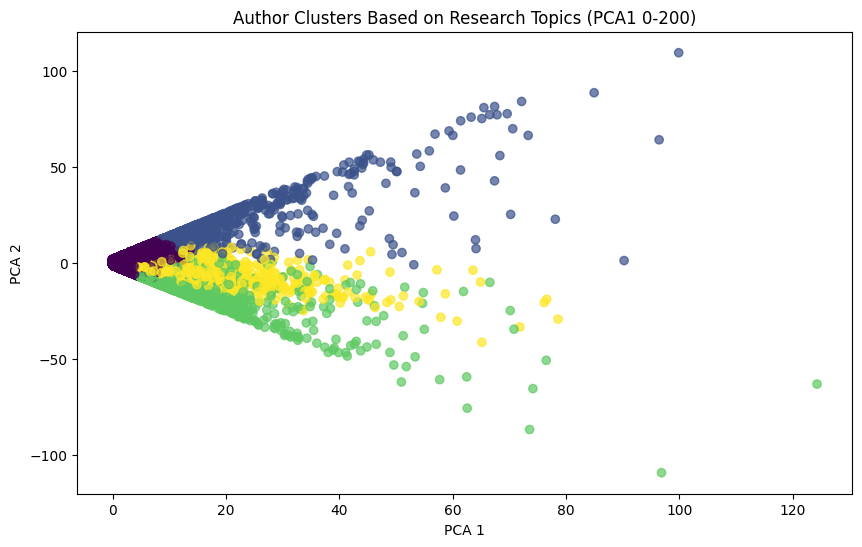

In [155]:
mask = (coords[:,0] >= 0) & (coords[:,0] <= 125)

plt.figure(figsize=(10,6))
plt.scatter(coords[mask, 0], coords[mask, 1], c=authorMatrix['cluster'].values[mask], alpha=0.7)
plt.title("Author Clusters Based on Research Topics (PCA1 0-200)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

**Radar Chart**

In [156]:
cluster_profiles = authorMatrix.groupby('cluster').mean()
cluster_profiles

category,Applications (Statistics),Artificial Intelligence,Computation and Language (Legacy category),Computation and Language (Natural Language Processing),Computer Vision and Pattern Recognition,Computers and Society,Cryptography and Security,"Distributed, Parallel, and Cluster Computing",Human-Computer Interaction,Information Retrieval,Machine Learning,Machine Learning (Statistics),Methodology (Statistics),Neural and Evolutionary Computing,Neurons and Cognition,Optimization and Control,Robotics,Signal Processing,Social and Information Networks,Software Engineering
cluster,,,,,,,,,,,,,,,,,,,,
0,0.005236,0.218177,0.007385,0.445402,0.501613,0.010325,0.013233,0.007483,0.008587,0.017645,0.628986,0.141829,0.013070,0.092115,0.007753,0.009453,0.019649,0.008582,0.007028,0.008251
1,0.003788,1.327020,0.093434,29.559343,1.987374,0.026515,0.047980,0.010101,0.029040,0.330808,2.901515,0.248737,0.017677,0.169192,0.005051,0.017677,0.047980,0.018939,0.092172,0.044192
2,2.000000,282.000000,4.000000,279.000000,160.000000,24.000000,8.000000,0.000000,5.000000,0.000000,279.000000,36.000000,2.000000,28.000000,5.000000,15.000000,29.000000,0.000000,0.000000,0.000000
3,0.005486,0.647335,0.001567,1.692790,22.518025,0.009404,0.059561,0.021944,0.014890,0.104232,3.682602,0.435737,0.017241,0.281348,0.014107,0.041536,0.094828,0.025862,0.033699,0.025078
4,0.021436,1.568596,0.004823,1.979636,2.277599,0.035370,0.099678,0.060557,0.020364,0.171490,17.426045,3.535906,0.076099,0.636656,0.025723,0.207395,0.096999,0.031083,0.101286,0.032690


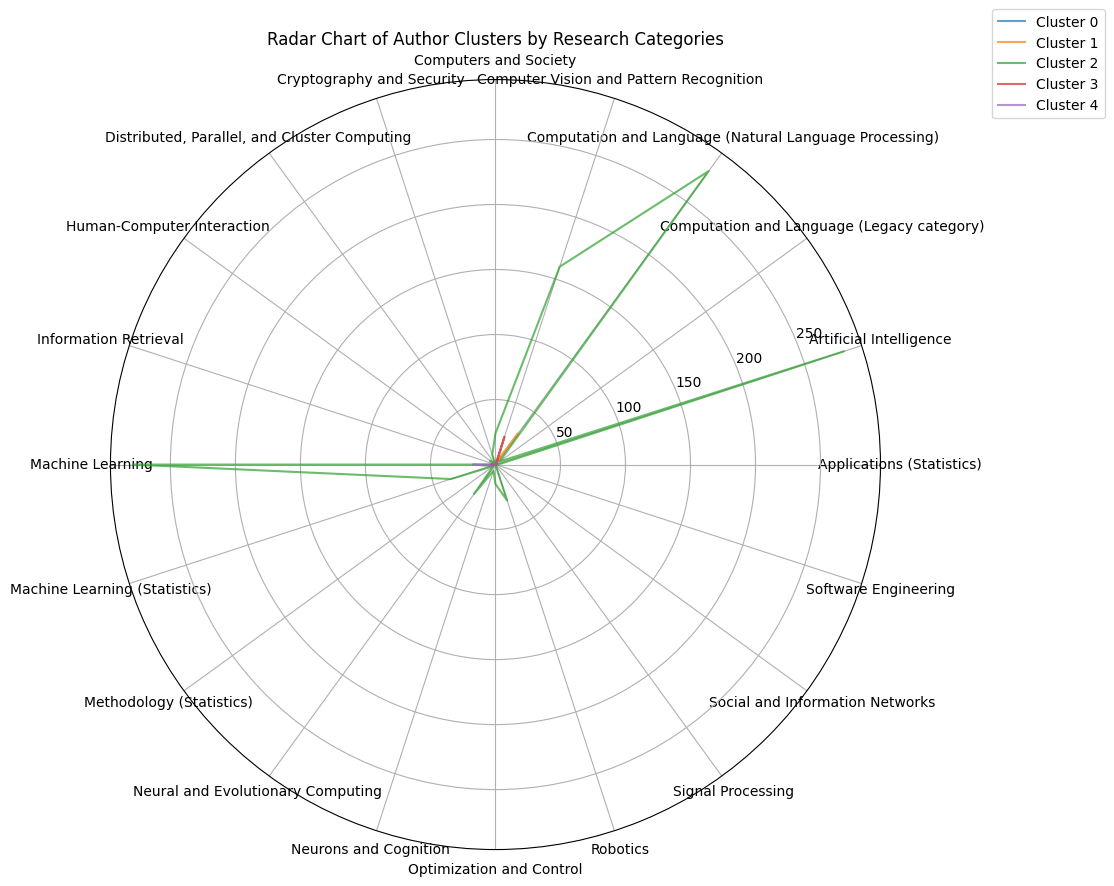

In [157]:
categories = list(cluster_profiles.columns)  # top 20 topics
N = len(categories)

# Angles for radar chart
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

# Plot radar chart for each cluster
plt.figure(figsize=(10, 10))
for i, row in cluster_profiles.iterrows():
    values = row.tolist()
    values += values[:1]  # close the loop
    plt.polar(angles, values, label=f"Cluster {i}", alpha=0.7)

# Add category labels
plt.xticks(angles[:-1], categories, rotation=45, fontsize=10)
plt.title("Radar Chart of Author Clusters by Research Categories")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

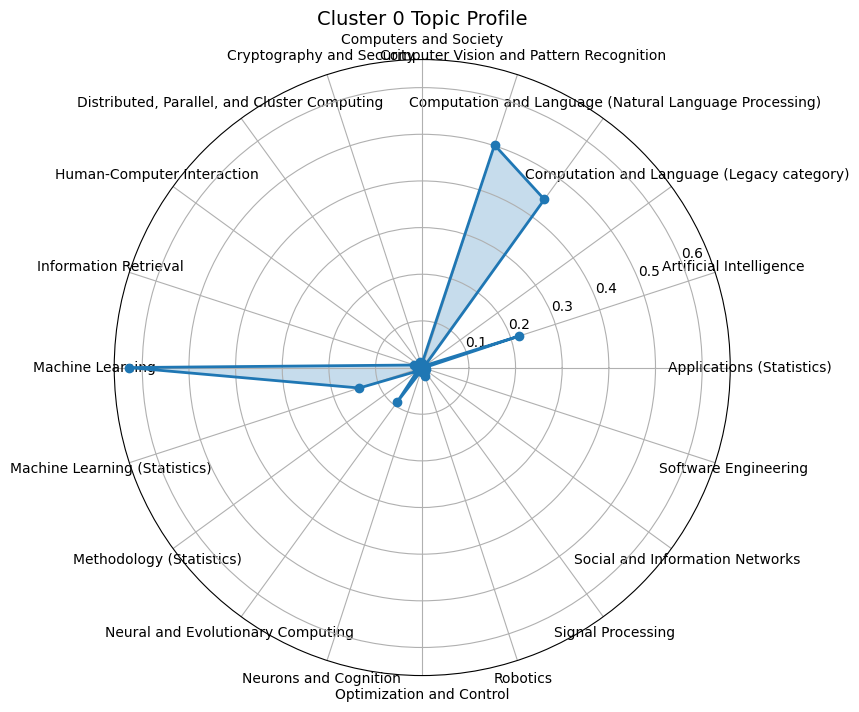

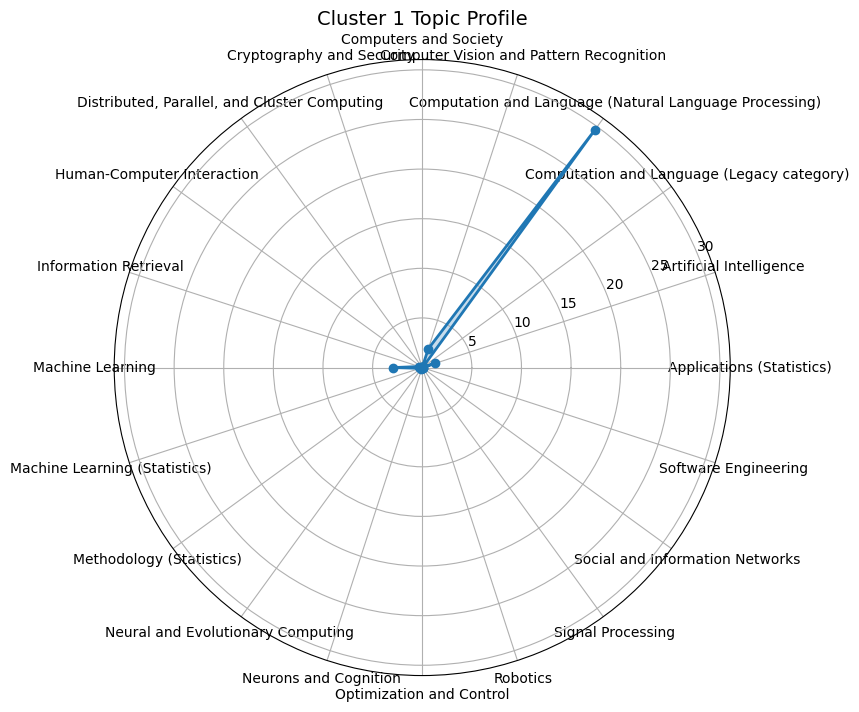

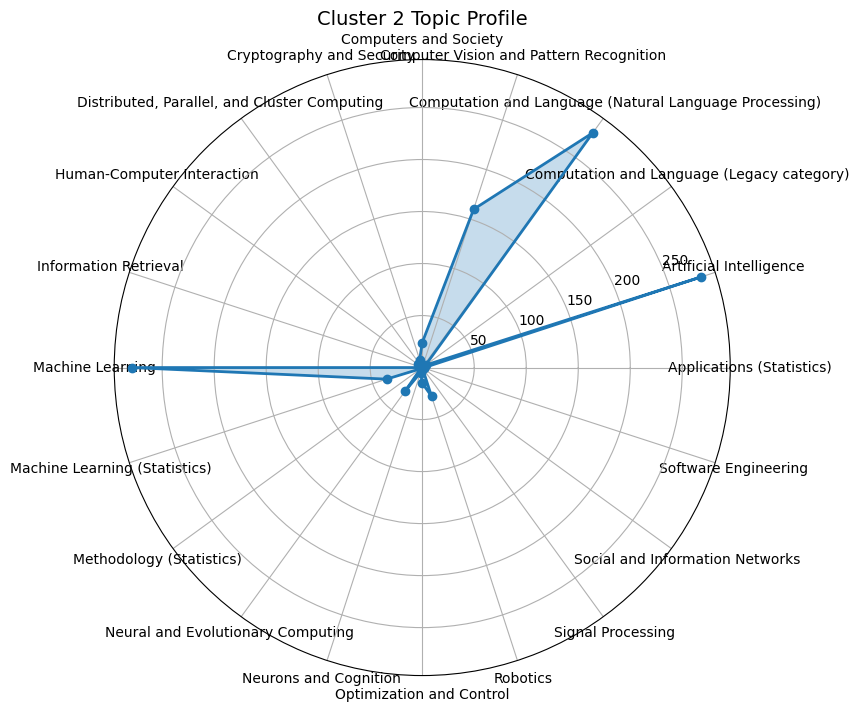

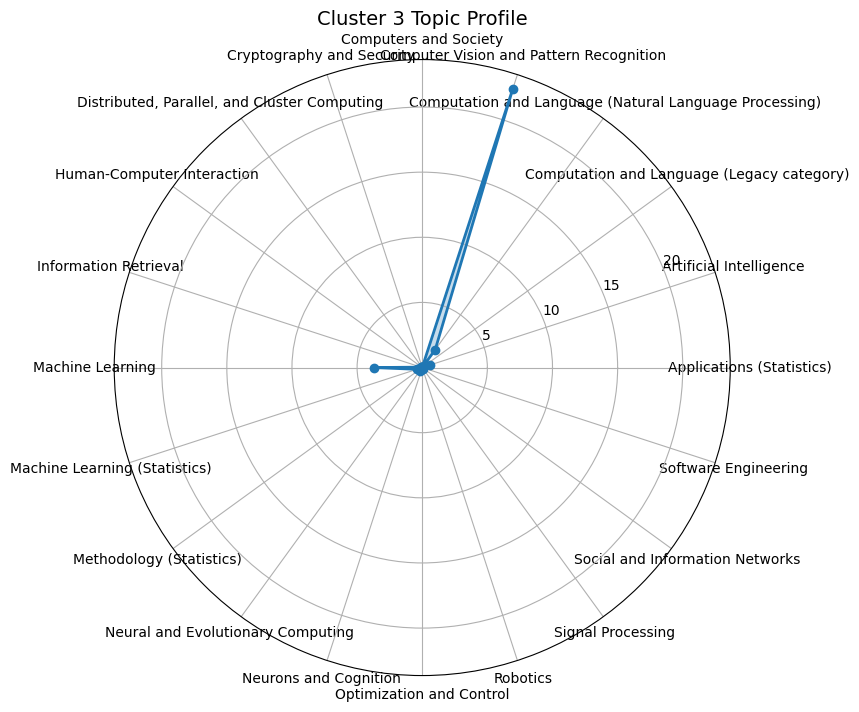

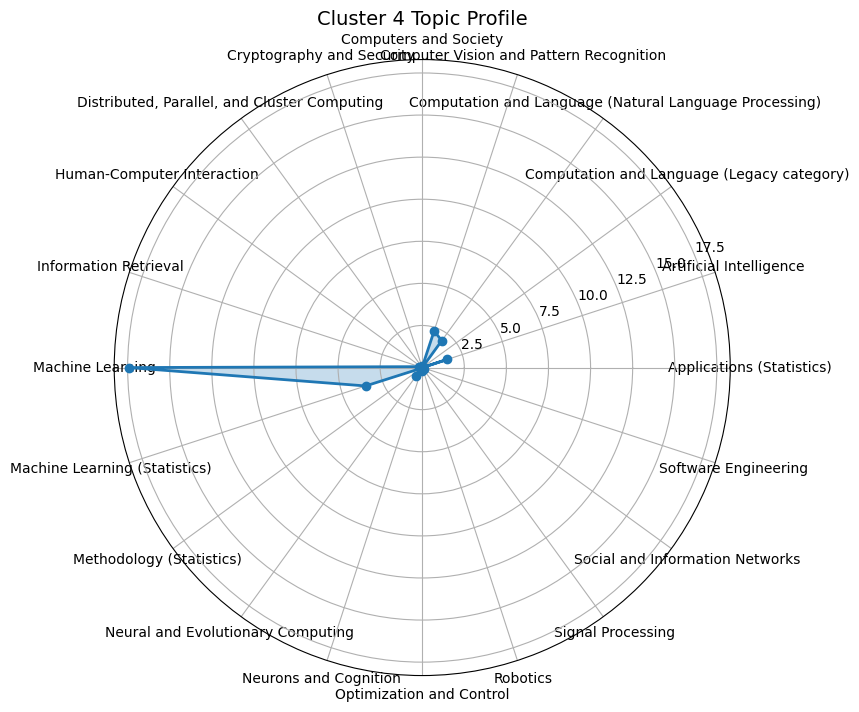

In [158]:
categories = list(cluster_profiles.columns)
N = len(categories)

# Compute angles for radar chart
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

for cluster_id, row in cluster_profiles.iterrows():
    values = row.tolist()
    values += values[:1]  # close the loop

    plt.figure(figsize=(8,8))
    plt.polar(angles, values, marker='o', linewidth=2)
    plt.fill(angles, values, alpha=0.25)
    plt.xticks(angles[:-1], categories, rotation=45, fontsize=10)
    plt.title(f"Cluster {cluster_id} Topic Profile", size=14)
    plt.show()